# Classification

* MNINST: dataset of 70k images handwritten by high-school student.
  * Often called "Hello world" of classification problems.
* Can download using Scikit helper functions:

In [1]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

* Datasets in Scikit are a dictionary, with a description (``DESCR``) and the data and target columns.

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


* Set has 70k images, each with 784 features.
* Each image is 28x28 pixels, with each pixel represented as an intensity score from 0 (white) to 255 (black).

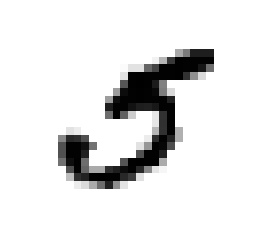

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(
    some_digit_image, cmap=matplotlib.cm.binary,
    interpolation='nearest')
plt.axis('off')
plt.show()

* Dataset is already split into training and test set: first 60k images is training and last 10k is test:

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

* Should shuffle the dataset to ensure cross validation folds aren't missing numbers.
* Also, some algos are sensitive to seeing too many of the same class in a row.

In [5]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

* We create a simple model that distinguishes between 2 and not 2 (binary classifier):

In [6]:
y_train_2 = (y_train == 2)
y_test_5 = (y_test == 2)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_2)

sgd_clf.predict([some_digit])

array([False], dtype=bool)

* Evaluate the model using K-fold cross-validation with 3 folds:

In [7]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_2, cv=3, scoring='accuracy')

array([ 0.9735 ,  0.97165,  0.9711 ])

* Accuracy seems good, but so does a classifier that always picks not 2 because 90% of the images are not 2:

In [8]:
from sklearn.base import BaseEstimator

class Never2Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [9]:
never_2_clf = Never2Classifier()
cross_val_score(never_2_clf, X_train, y_train_2, cv=3, scoring='accuracy')

array([ 0.90545,  0.89805,  0.8986 ])

* Accuracy is not always the best performance measure, especially on a skewed dataset.
* Confusion matrix general idea: count number of times some class is classified as some other class.

In [10]:
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3)

confusion_matrix(y_train_2, y_train_pred)

/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([[53581,   461],
       [ 1214,  4744]])

* Confusion matrix is organised as follows:

  ```
  Negative: True, False
  Positive: False, True
  ```

* Accuracy of positive predictions is called "precision".
  * Number of true positives, over true positives and false positives.

   $ precision = \frac{TP}{TP + FP} $
 
   * How many did we get right vs wrong.
   
* Recall looks at how many true positives we missed:

 $ recall = \frac{TP}{TP + FN} $

* Scikit provides a bunch of functions for calculating said scores: ``precision_score`` and ``recall_score``.

In [11]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_2, y_train_pred))
print(recall_score(y_train_2, y_train_pred))

0.911431316042
0.79624034911


* Can combine the scores into a single metric called the "F1 score".
  * Harmonic mean of the two scores:
    * Harmonic mean gives a higher weight to lower scores, meaning the classifier will only get a high F if both are high.

In [12]:
from sklearn.metrics import f1_score

f1_score(y_train_2, y_train_pred)

0.8499507300904775

* Increasing precision reduces recall: precision / recall trade off.
* Can get access to decision scores for each instance using the ``decision_function`` method.

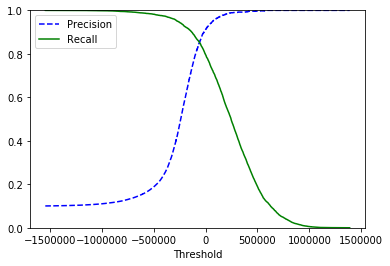

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### ROC curve

* Receiver Operating Characteristic (ROC).
* Similar to precision/recall curve, but plots the **True Positive Rate** (aka recall) against **False Positive Rate**.
  * Basically, tells you ratio of negative instances incorrectly classed as positive.
  * FPR is equal to 1 - True Negative Rate (TNR).
  * TNR is also called "specificity", so the ROC plots sensitivity (recall) vs 1 - specificity.

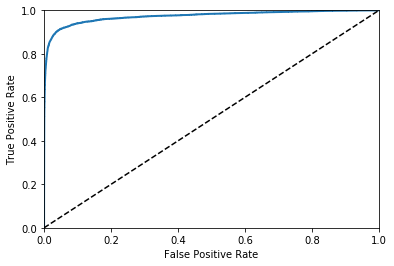

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

* Can compare classifiers by measuring the area under the curve using ``roc_auc_score``.
  * A perfect classifier will be equal to one, a random (in the binary case) will be equal to 0.5.

In [16]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_2, y_scores)

0.97295196434377207

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_2, cv=3, method='predict_proba')

In [20]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_2, y_scores_forest)

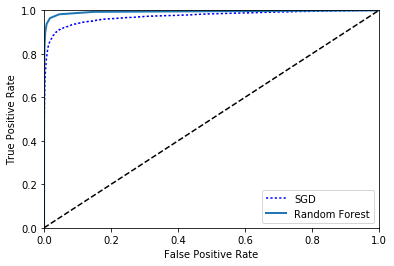

In [23]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [24]:
roc_auc_score(y_train_2, y_scores_forest)

0.9935510200009916

* Random Forest appears to before much better than SGD.

## Multiclass classification

* Multiclass, aka multinomial classifiers, can be used to distinguish between multiple classes.
* Some algo have multiclass built in: Random Forest, Naive Bayes, others are binary.
  * Binary classifiers can be converted to multiclass by using one-vs-all or one-vs-rest strategies.
* One-vs-all: train a classifier for each label, then at prediction time, pick the classifier with the higher probability.
* One-vs-one: train a classifier for every pair. Eg: 2 and 3s, 3s and 4s.
  * Useful for algos that don't cope well with huge training datasets.
* Scikit detects multiclass problems and auto uses OvA under the hood (except for SVM which uses OvO).

In [25]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 0.])

In [26]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -55924.16498482, -324755.46851594, -498444.01811445,
        -255467.08131258, -344917.55237986,  -88340.70080847,
        -797412.14483959, -292340.8760254 , -627019.40039483,
        -615689.15134108]])

* Note how the highest score corresponds to 0 there.

### Error Analysis

* One way to improve a model is to analyze the types of errors it makes.
  * Can make predictions with ``cross_val_predict()`` and call ``confusion_matrix()`` on it:

In [29]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5742,    2,   11,    9,   11,   21,   33,   12,   77,    5],
       [   3, 6561,   26,   19,    1,   40,    6,   15,   56,   15],
       [ 137,  149, 4894,  157,   64,   40,  111,   91,  282,   33],
       [  88,   38,  154, 5179,    8,  295,   28,   66,  209,   66],
       [ 135,   58,   24,   17, 5015,   30,   40,   36,  106,  381],
       [ 189,   54,   35,  270,   63, 4059,   81,   23,  588,   59],
       [ 188,   59,   34,    5,   52,  145, 5347,    4,   71,   13],
       [  75,   42,   51,   44,   52,   17,    3, 5680,   51,  250],
       [ 132,  271,   73,  173,   44,  270,   32,   32, 4728,   96],
       [  87,   57,   16,  116,  252,  110,    1,  458,  110, 4742]])

* Can use Matplotlib's ``mathshow`` to see an image representation of the confusion matrix:

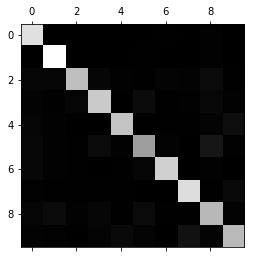

In [30]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()